# MLv4: ASO Data
Tony Cannistra | Mar 2018

We're going to try to use previously-extracted ASO data (in `../images/ASO/`) to train the model. It's a really huge quantity so I'm not sure if it'll work. 

In [30]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from functools import partial
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.gaussian_process import GaussianProcessClassifier, kernels
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib

# need parallelism for training
from multiprocessing import Pool
_pool = Pool(processes=5)

# configure plotting
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [31]:
# start with raw luminance
snowOnFile  = "../images/ASO/0_20170401_175413_1024_cropped.pkl"
snowOffFile = "../images/ASO/0_20160620_191028_0c79_cropped.pkl"
snowOnData  = pd.read_pickle(snowOnFile)
snowOffData = pd.read_pickle(snowOffFile)

In [32]:
# add class labels
snowOnData['label'] = 1
snowOffData['label'] = 0

In [33]:
# merge and shuffle
data = pd.concat([snowOnData, snowOffData], axis=0)
data = data.sample(frac=1)
print("{:d} | 0: {:d}, 1: {:d}".format(len(data),
                                      len(data[data.label == 0]), 
                                      len(data[data.label == 1])))

12831789 | 0: 6446071, 1: 6385718


## Model Evaluation
We'll scale the data first. **We'll use all bands, too**. We're only using HALF of the ASO data. 

In [34]:
bands = ['band1', 'band2', 'band3', 'band4']
sample = data.sample(5000)
X = np.array(sample[bands])
y = np.array(sample.label)
X = StandardScaler().fit_transform(X)

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [35]:
X.shape

(5000, 4)

Same training options as before. 

In [36]:
# we'll define the different classifiers to  test here. 
simple_gpc = {
    'n_jobs' : -1, # use threads
}

kernel_gpc_noopt = {
    'n_jobs'    : -1, 
    'kernel'    : 1.0 * kernels.RBF(length_scale=1.0),
    'optimizer' : None
}

kernel_gpc_opt = {
    'n_jobs' : -1, 
    'kernel' : 1.0 * kernels.RBF(length_scale=1.0)
    # default optimizer
}

paramsets = [kernel_gpc_opt]#, kernel_gpc_noopt, kernel_gpc_opt]

In [37]:
accuracies = []
folder = StratifiedKFold(5)
for params in paramsets:
    gpc = GaussianProcessClassifier(**params)
    acc = cross_val_score(gpc, X, y, cv=folder, n_jobs=-1)
    accuracies.append(np.mean(acc))
        
print(accuracies)

[0.9992000000000001]


That's got to be a bad sign.

## Model Training + Persistence

In [38]:
model_params = kernel_gpc_opt
model = GaussianProcessClassifier(**model_params)
model.fit(X, y)


GaussianProcessClassifier(copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1), max_iter_predict=100,
             multi_class='one_vs_rest', n_jobs=-1, n_restarts_optimizer=0,
             optimizer='fmin_l_bfgs_b', random_state=None,
             warm_start=False)

In [39]:
model_outfile_name = "snowcover-model-ASO.pkl"
joblib.dump(model, model_outfile_name)


['snowcover-model-ASO.pkl']

In [40]:
!du -hc snowcover-model-ASO.pkl

192M	snowcover-model-ASO.pkl
192M	total


In [41]:
model.kernel_

316**2 * RBF(length_scale=1.28)

In [49]:

X_all = X
y_all = X
_, snowOnProbs = zip(*model.predict_proba(X_all))

Text(0.5,0.98,'GPC Probabilistic Performance')

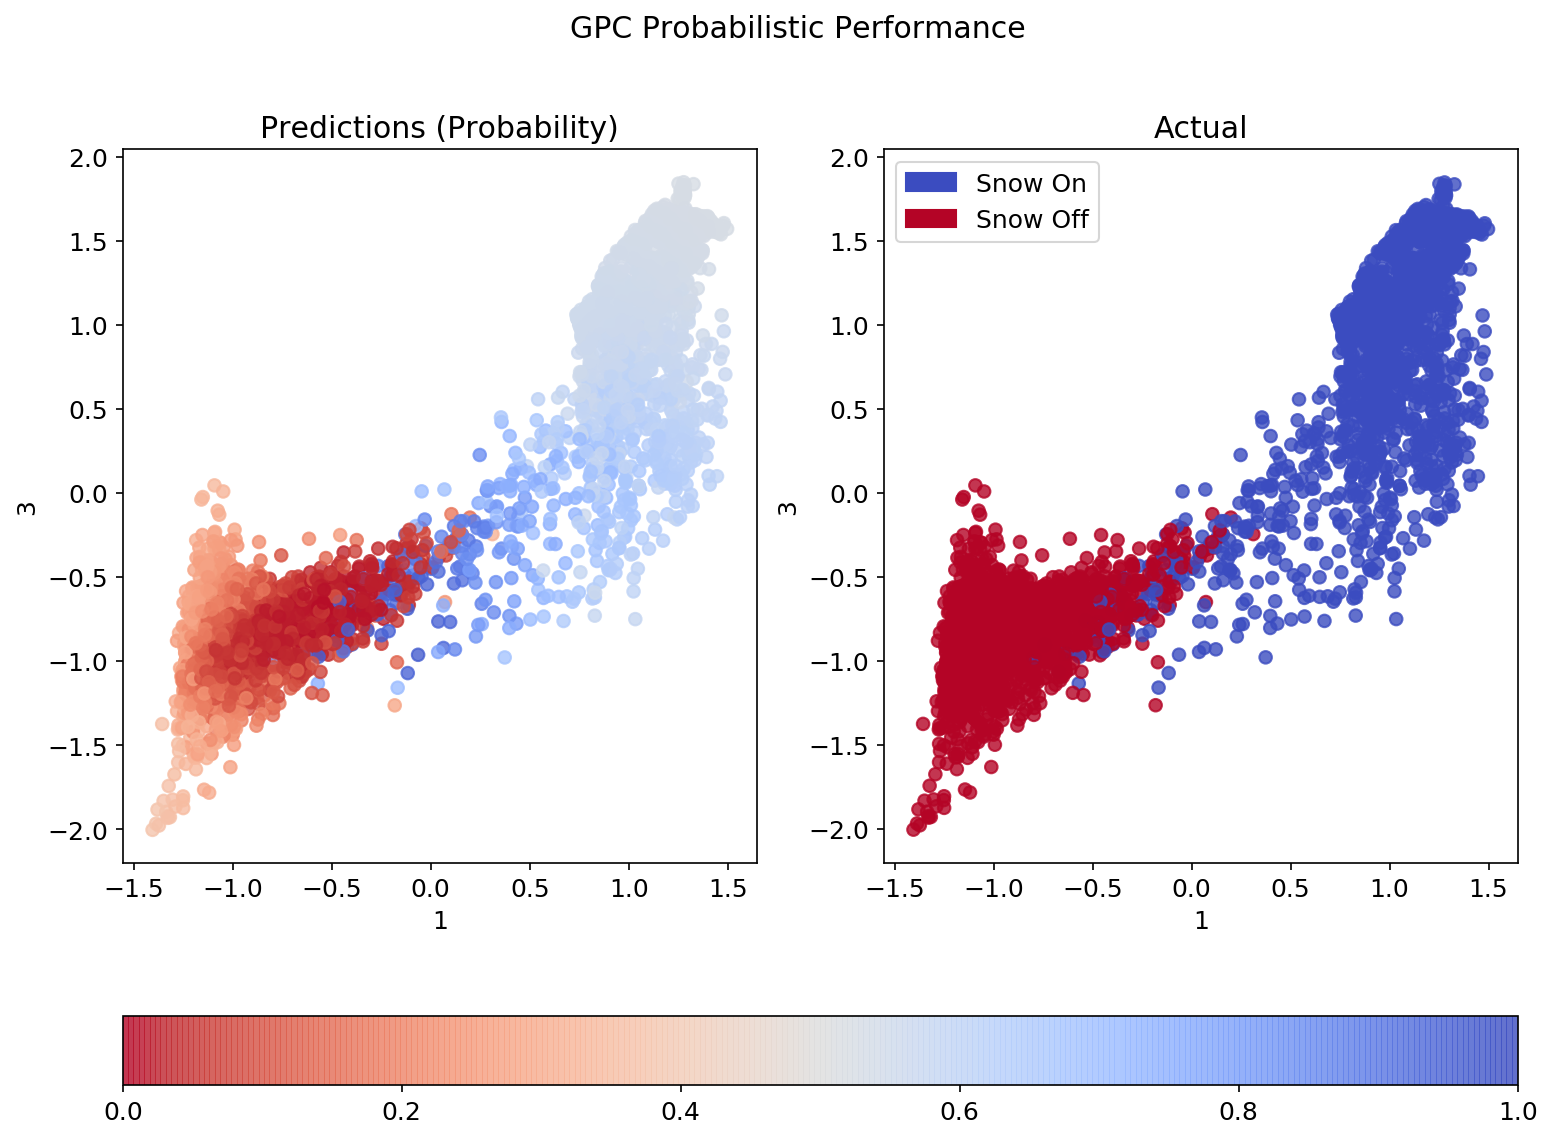

In [54]:
# which bands to plot?
b1 = 1
b2 = 3
preds = snowOnProbs

cmap = plt.get_cmap("coolwarm_r")

binary_colors = np.array([cmap(0), cmap(1)])

fig, axes = plt.subplots(1, 2)
ax1, ax2 = axes
s1 = ax1.scatter(list(X[:,b1]), list(X[:,b2]), c = preds, cmap=cmap, alpha=0.8, vmin=0, vmax=1)
ax1.set_title("Predictions (Probability)")
ax1.set_xlabel(b1)
ax1.set_ylabel(b2)
fig.colorbar(s1, orientation='horizontal', ax=axes.ravel().tolist())

ax2.scatter(list(X[:,b1]), list(X[:,b2]), c = y, cmap=cmap, alpha=0.8)
ax2.set_title("Actual")
ax2.set_xlabel(b1)
ax2.set_ylabel(b2)

nosnow_patch = patches.Patch(color=cmap(0.999999), label="Snow On")
snow_patch = patches.Patch(color=cmap(0), label='Snow Off')

#ax1.legend(handles=[nosnow_patch, snow_patch])
ax2.legend(handles=[nosnow_patch, snow_patch])

# incorrect = abs(preds - merged.label)
# ax3.set_title("Mistakes")
# ax3.scatter(merged[b1], merged[b2], color=colors[incorrect], alpha=0.9)
# right_patch = patches.Patch(color=colors[0], label="Correct")
# wrong_patch = patches.Patch(color=colors[1], label='Incorrect')

# ax1.legend(handles=[nosnow_patch, snow_patch])
# ax2.legend(handles=[nosnow_patch, snow_patch])
# ax3.legend(handles=[right_patch, wrong_patch])

fig.suptitle("GPC Probabilistic Performance")
#plt.tight_layout(w_pad=0.9)



/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 5000 + 1) instead
  """Entry point for launching an IPython kernel.


array([1660, 2802,  544, 2054, 2903, 1791, 2747, 1565, 2609, 4698, 2807,
       3991, 2574, 3817, 1059, 4753, 3327,  178, 1119, 3027,  642, 1374,
        945, 1822, 3065, 2841, 1215, 2107, 4942, 1698, 2374, 2139, 1877,
       4032, 4167, 3161,  438, 2790, 1069, 1474, 4554, 3255,   22,  402,
       4325, 4650,  385, 2564, 1118, 2693])

Text(0.5,0.98,'GPC Threshold Performance (acc: 100.000000)')

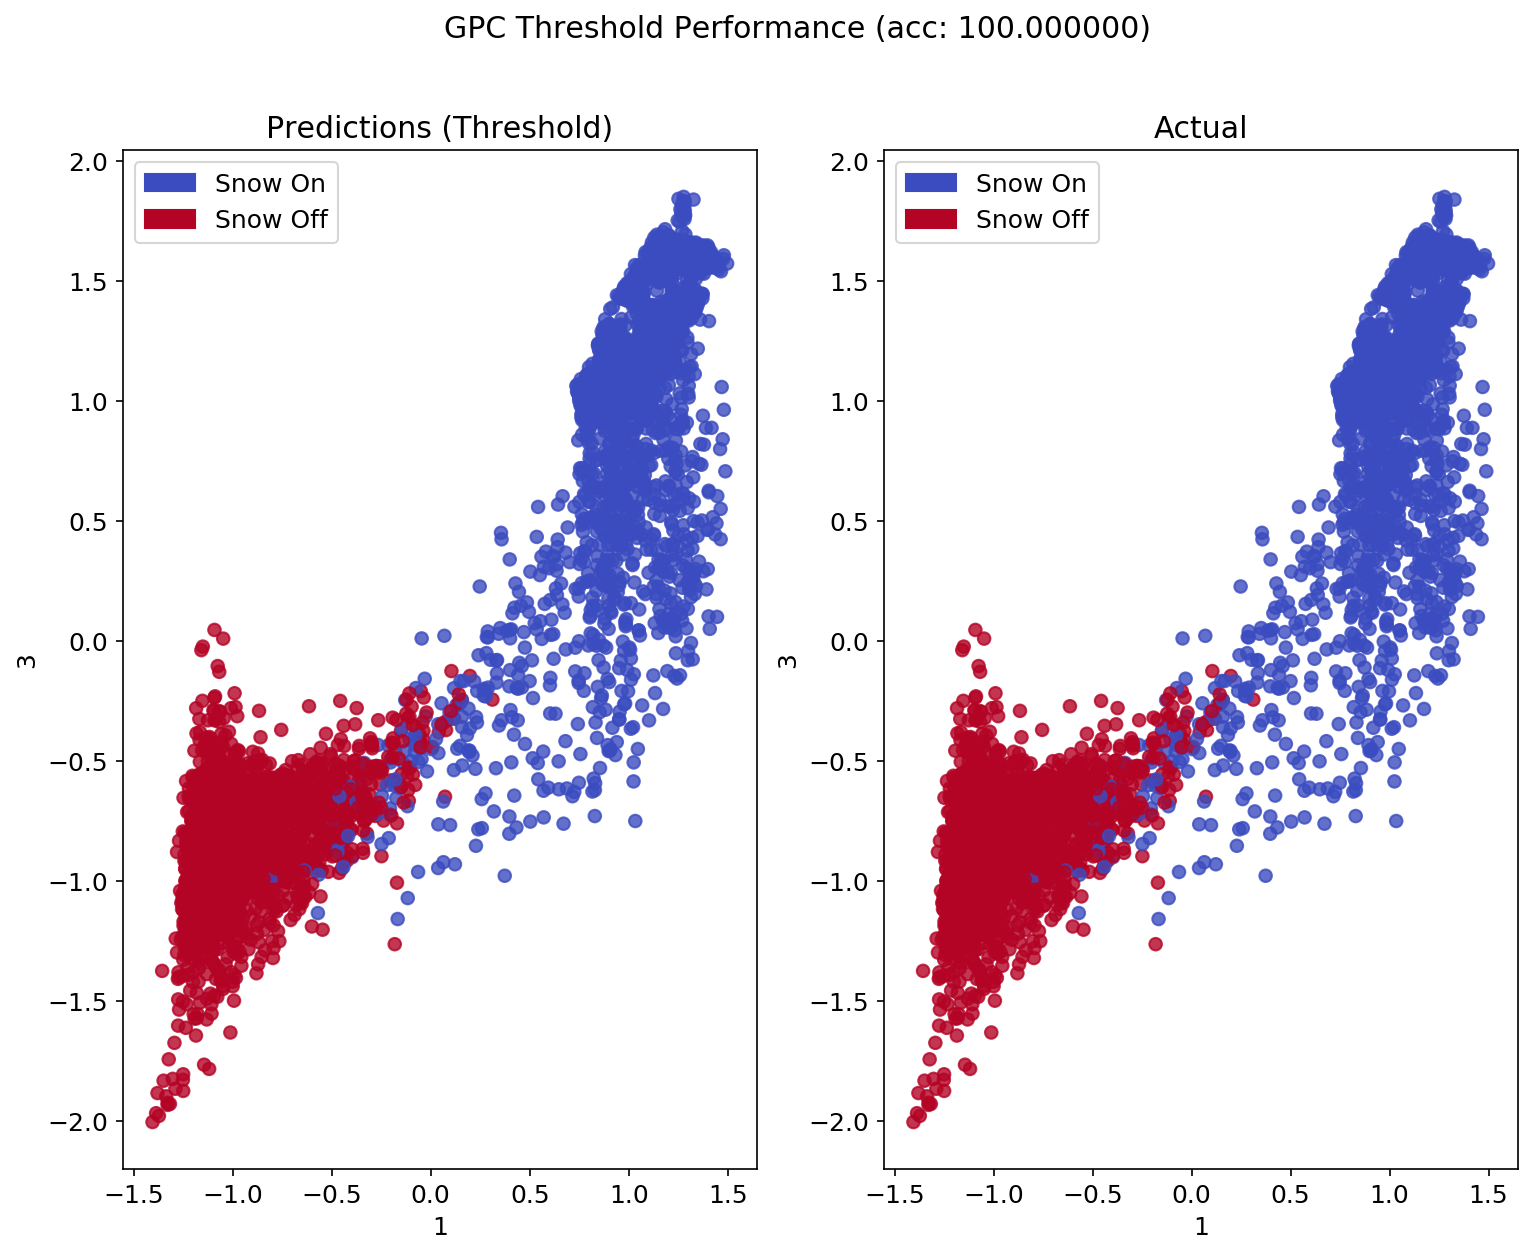

In [57]:
# which bands to plot?

actualPreds = model.predict(X)
accuracy = accuracy_score(y, actualPreds)

cmap = plt.get_cmap("coolwarm_r")

binary_colors = np.array([cmap(0), cmap(1)])

fig, (ax1, ax2) = plt.subplots(1, 2)
s1 = ax1.scatter(X[:,b1], X[:,b2], c = preds, cmap=cmap, alpha=0.8, vmin=0, vmax=1)
ax1.set_title("Predictions (Threshold)")
ax1.set_xlabel(b1)
ax1.set_ylabel(b2)
#plt.colorbar(s1, ax=ax1, orientation='horizontal')

ax2.scatter(X[:,b1], X[:,b2], c = y, cmap=cmap, alpha=0.8)
ax2.set_title("Actual")
ax2.set_xlabel(b1)
ax2.set_ylabel(b2)

nosnow_patch = patches.Patch(color=cmap(0.999999), label="Snow On")
snow_patch = patches.Patch(color=cmap(0), label='Snow Off')

ax1.legend(handles=[nosnow_patch, snow_patch])
ax2.legend(handles=[nosnow_patch, snow_patch])

# incorrect = abs(preds - merged.label)
# ax3.set_title("Mistakes")
# ax3.scatter(merged[b1], merged[b2], color=colors[incorrect], alpha=0.9)
# right_patch = patches.Patch(color=colors[0], label="Correct")
# wrong_patch = patches.Patch(color=colors[1], label='Incorrect')

# ax1.legend(handles=[nosnow_patch, snow_patch])
# ax2.legend(handles=[nosnow_patch, snow_patch])
# ax3.legend(handles=[right_patch, wrong_patch])

fig.suptitle("GPC Threshold Performance (acc: {:f})".format(accuracy * 100))

#plt.tight_layout(w_pad=0.9)



In [78]:
rand_indices = np.random.randint(0, len(X)-1, 5000)
thosedata = data.iloc[rand_indices]
X = np.array(thosedata[bands])
y = np.array(thosedata.label)
X = StandardScaler().fit_transform(X)
_, snowOnProbs = zip(*model.predict_proba(X))

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Text(0.5,0.98,'GPC Probabilistic Performance')

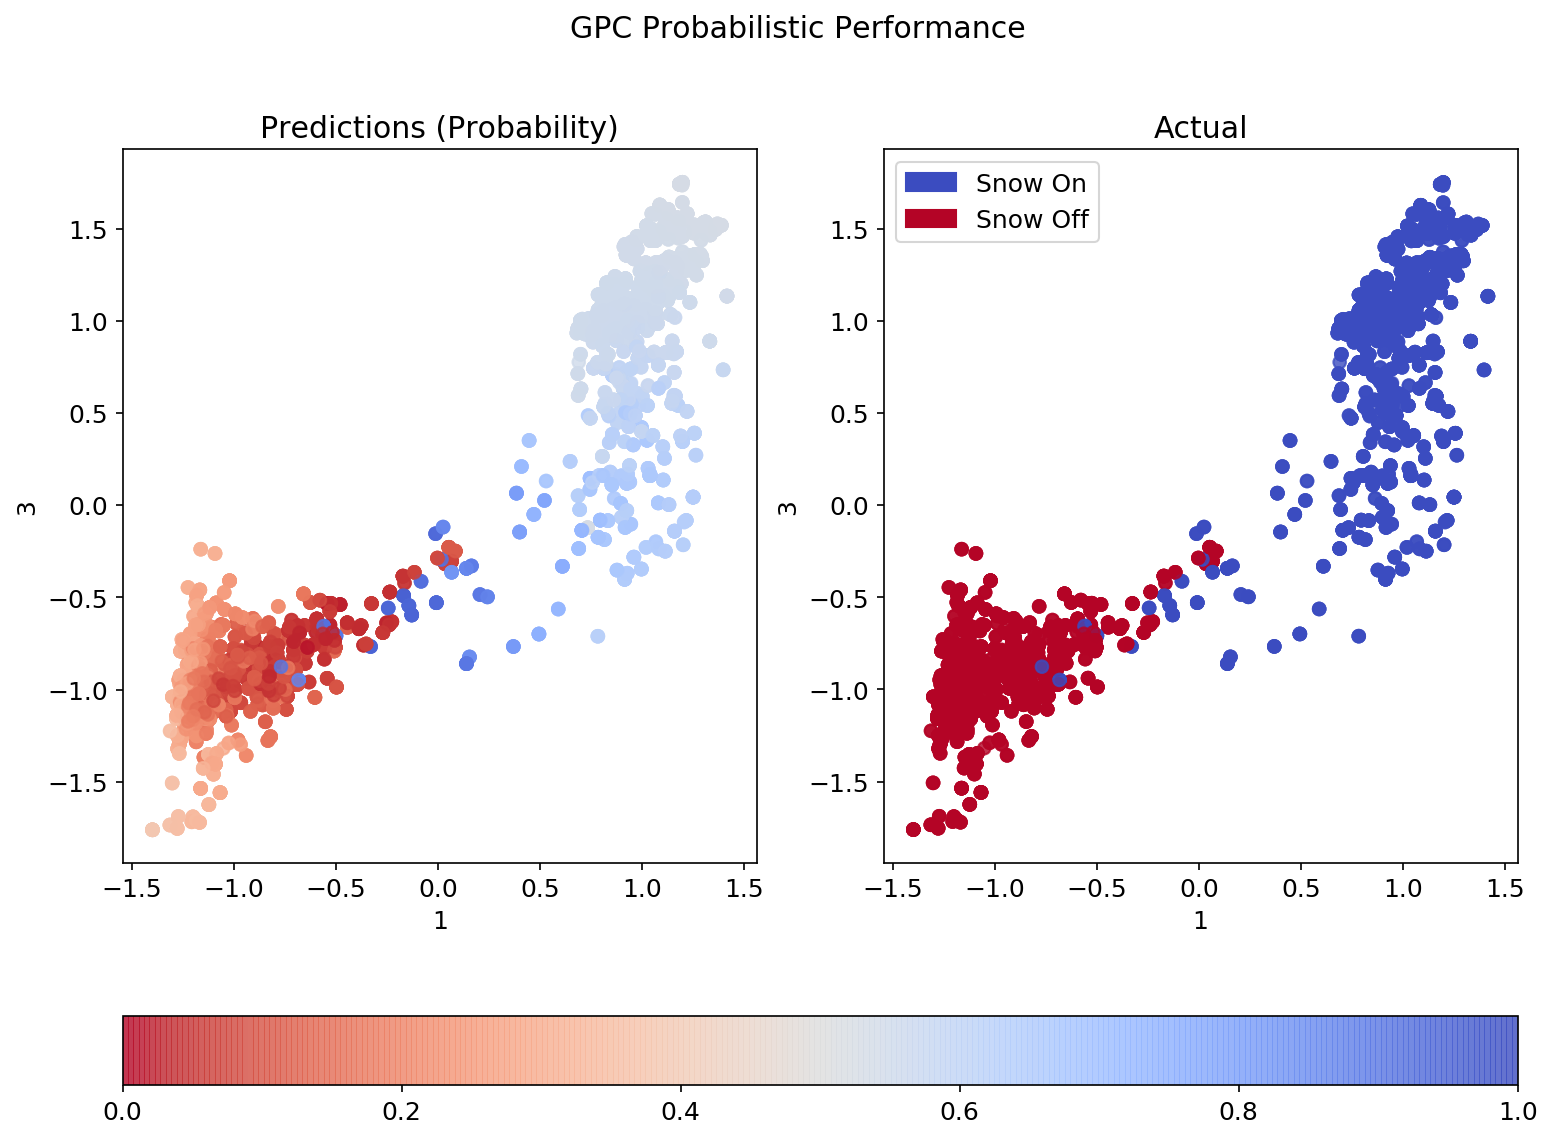

In [79]:
# which bands to plot?
b1 = 1
b2 = 3
preds = snowOnProbs

cmap = plt.get_cmap("coolwarm_r")

binary_colors = np.array([cmap(0), cmap(1)])

fig, axes = plt.subplots(1, 2)
ax1, ax2 = axes
s1 = ax1.scatter(list(X[:,b1]), list(X[:,b2]), c = preds, cmap=cmap, alpha=0.8, vmin=0, vmax=1)
ax1.set_title("Predictions (Probability)")
ax1.set_xlabel(b1)
ax1.set_ylabel(b2)
fig.colorbar(s1, orientation='horizontal', ax=axes.ravel().tolist())

ax2.scatter(list(X[:,b1]), list(X[:,b2]), c = y, cmap=cmap, alpha=0.8)
ax2.set_title("Actual")
ax2.set_xlabel(b1)
ax2.set_ylabel(b2)

nosnow_patch = patches.Patch(color=cmap(0.999999), label="Snow On")
snow_patch = patches.Patch(color=cmap(0), label='Snow Off')

#ax1.legend(handles=[nosnow_patch, snow_patch])
ax2.legend(handles=[nosnow_patch, snow_patch])

# incorrect = abs(preds - merged.label)
# ax3.set_title("Mistakes")
# ax3.scatter(merged[b1], merged[b2], color=colors[incorrect], alpha=0.9)
# right_patch = patches.Patch(color=colors[0], label="Correct")
# wrong_patch = patches.Patch(color=colors[1], label='Incorrect')

# ax1.legend(handles=[nosnow_patch, snow_patch])
# ax2.legend(handles=[nosnow_patch, snow_patch])
# ax3.legend(handles=[right_patch, wrong_patch])

fig.suptitle("GPC Probabilistic Performance")
#plt.tight_layout(w_pad=0.9)

